# Ejercicio 4 - Optimizar la gestión de la memoria

El programa que se muestra, es poco óptimo en el sentido de que implica movimientos de datos entre la CPU y la GPU.

---

Modificarlo para que a la salida de la función **`pulses()`** los datos
queden en la GPU y sean utilizados directamente por la función
**`add_ufunc()`**



In [ ]:
### EVITAR ERRORES

!uv pip install -q --system numba-cuda==0.4.0

from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


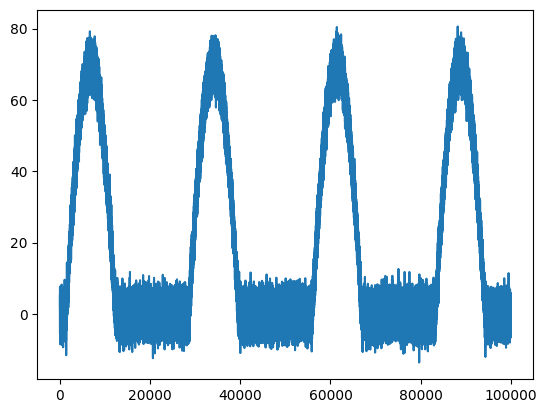

In [ ]:
### CÓDIGO SIN CORREGIR ###

import math
from numba import vectorize, cuda
from matplotlib import pyplot as plt
import numpy as np

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

n = 100000
period = n / 23
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)

pulses = make_pulses(t, period, 100.0).astype(np.float32)
waveform = add_ufunc(pulses, noise)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(waveform)
fig.show()

/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


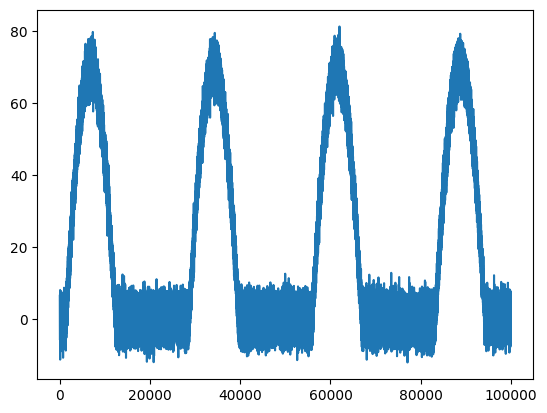

In [ ]:
### CÓDIGO CORREGIDO ###
import math
from numba import vectorize, cuda
from matplotlib import pyplot as plt
import numpy as np

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

n = 100000
period = n / 23

# Generamos los datos directamente en la CPU
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)

# Movemos t y noise a la GPU
d_t = cuda.to_device(t)
d_noise = cuda.to_device(noise)

# Ejecutamos make_pulses directamente en la GPU, el resultado también estará en la GPU
d_pulses = make_pulses(d_t, period, 100.0)

# Sumamos en la GPU sin traer nada de vuelta
d_waveform = add_ufunc(d_pulses, d_noise)

# Solo ahora traemos el resultado final de la GPU a la CPU para graficar
waveform = d_waveform.copy_to_host()

# Graficamos el resultado
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(waveform)
fig.show()
